# 火锅团购数据分析  —— 何数学

In [578]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imageio import imread
from wordcloud import WordCloud
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS 
import warnings
warnings.filterwarnings('ignore')
# from statsmodels.formula.api import ols

## >>> Q1：数据读入与预处理

**数据读入：**

In [698]:
data = pd.read_csv(r'.\HotPot.csv')
data.head()

,ID,字段1,字段2,discount,price,privilege.for.new,privilege.on.sale,district,if.nonworkdays.available,time.duration,...,quarterly.sales.volume,level.of.participants.limited,level.of.tickets.limited,place,food,taste,cook,people,style,HighFreq
0,1,巴蜀大魏道火锅(高新路店),仅售308元，价值372元6人餐！免费WiFi节假日通用，可使用包间！,0.827957,308.0,钱包新客最高再减20元,无立减优惠,高新区,周末法定节假日通用,24.0,...,5.416667,不限人数,不限张数,是,否,否,否,否,川系,2
1,10,宽窄巷子火锅,仅售79.9元，价值100元代金券！可使用包间，免费停车，免费WiFi！,0.799000,79.9,钱包新客最高再减20元,无立减优惠,高新区,周末法定节假日通用,12.0,...,1874.198473,不限人数,不限张数,否,否,否,否,否,川系,1
2,100,重庆鼻祖老火锅,仅售90元，价值100元代金券！可叠加使用，免费WiFi，可使用包间，免费WiFi！,0.900000,90.0,钱包新客最高再减20元,无立减优惠,雁塔区,非周末法定节假日通用,11.0,...,466.758621,不限人数,不限张数,是,否,否,否,否,川系,3
3,1000,六婆串串香火锅(凤城一路店),仅售1元，价值12元凤城一路店大签30个！节假日通用，提供免费WiFi，免费WiFi！,0.083333,1.0,钱包新客最高再减20元,无立减优惠,未央区,周末法定节假日通用,10.0,...,2.241993,不限人数,不限张数,否,否,是,否,是,川系,4
4,1001,辣尚仙焖锅,仅售68元，最高价值128元咸宁中路店双人菌类套餐！?,0.531250,68.0,钱包新客最高再减20元,无立减优惠,新城区,非周末法定节假日通用,11.0,...,6.443418,限2-4人,不限张数,否,否,是,是,否,川系,4


In [672]:
# 查看列名
data.columns

Index(['ID', '字段1', '字段2', 'discount', 'price', 'privilege.for.new',
       'privilege.on.sale', 'district', 'if.nonworkdays.available',
       'time.duration', 'if.appointment.needed', 'WiFi.available', 'parking',
       'rooms.available', '评分', '评论数', 'online.intervel',
       'quarterly.sales.volume', 'level.of.participants.limited',
       'level.of.tickets.limited', 'place', 'food', 'taste', 'cook', 'people',
       'style', 'HighFreq'],
      dtype='object')

**检查是否有缺失值：**

In [673]:
data.isnull().any()

ID                               False
字段1                              False
字段2                              False
discount                         False
price                            False
privilege.for.new                False
privilege.on.sale                False
district                         False
if.nonworkdays.available         False
time.duration                    False
if.appointment.needed            False
WiFi.available                   False
parking                          False
rooms.available                  False
评分                               False
评论数                              False
online.intervel                  False
quarterly.sales.volume           False
level.of.participants.limited    False
level.of.tickets.limited         False
place                            False
food                             False
taste                            False
cook                             False
people                           False
style                    

**无缺失值。**

**后期想算团购套餐人均价格，因此按照level.of.participants.limited，粗略估计人数：**  

**'不限人数':6, '限1人':1, '限2-4人':3, '限5-12人':8**

In [674]:
data['num_people'] = data['level.of.participants.limited'].map( 
    {'不限人数':6, '限1人':1, '限2-4人':3, '限5-12人':8} )
data['price_per_person'] = data['price'] / data['num_people']

In [675]:
data[['price','level.of.participants.limited','num_people','price_per_person']].head()

,price,level.of.participants.limited,num_people,price_per_person
0,308.0,不限人数,6,51.333333
1,79.9,不限人数,6,13.316667
2,90.0,不限人数,6,15.000000
3,1.0,不限人数,6,0.166667
4,68.0,限2-4人,3,22.666667


In [676]:
data.describe()

,ID,discount,price,time.duration,评分,评论数,online.intervel,quarterly.sales.volume,HighFreq,num_people,price_per_person
count,2688.000000,2688.000000,2688.000000,2688.000000,2688.000000,2688.000000,2688.000000,2688.000000,2688.000000,2688.000000,2688.000000
mean,1548.107143,0.727246,109.735804,10.666877,3.167485,54.494420,341.178199,223.914485,1.924107,5.197545,22.997963
std,917.819049,0.149995,85.504943,3.253321,2.082107,310.282004,198.869675,1333.456790,1.096484,1.883280,16.511842
min,1.000000,0.014286,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.166667
25%,749.750000,0.637618,68.000000,10.000000,0.000000,0.000000,191.000000,1.414555,1.000000,3.000000,13.166667
50%,1540.500000,0.763359,86.050000,11.000000,4.400000,3.000000,320.500000,9.440904,2.000000,6.000000,16.500000
75%,2350.250000,0.850000,135.250000,12.000000,4.700000,22.000000,467.000000,55.794393,3.000000,6.000000,29.333333
max,3150.000000,0.999000,1365.000000,24.000000,5.000000,8032.000000,1143.000000,25941.428570,6.000000,8.000000,227.500000


**连续变量的总览，可看到取值范围差异非常大，后续需要处理。**

**将名义变量转为哑变量：**

In [677]:
# 名义变量列表，去掉字段1和字段2
nominal_list = [x for x in data.columns if x not in data.describe().columns]
nominal_list.remove('字段1')
nominal_list.remove('字段2')                    
print('名义变量列表：')
nominal_list

名义变量列表：


['privilege.for.new',
 'privilege.on.sale',
 'district',
 'if.nonworkdays.available',
 'if.appointment.needed',
 'WiFi.available',
 'parking',
 'rooms.available',
 'level.of.participants.limited',
 'level.of.tickets.limited',
 'place',
 'food',
 'taste',
 'cook',
 'people',
 'style']

In [678]:
# 查看各名义变量的具体取值
for rv in nominal_list:
    print(rv,data[rv].unique())

privilege.for.new ['钱包新客最高再减20元' '无钱包新客优惠']
privilege.on.sale ['无立减优惠' '有立减优惠']
district ['高新区' '雁塔区' '未央区' '新城区' '莲湖区' '灞桥区' '碑林区' '长安区' '阎良区' '临潼区']
if.nonworkdays.available ['周末法定节假日通用' '非周末法定节假日通用']
if.appointment.needed ['无需预约' '需预约']
WiFi.available ['免费WiFi' '未提及']
parking ['无停车位' '免费停车位' '未提及' '收费停车位']
rooms.available ['均可使用' '仅限大厅使用' '未提及']
level.of.participants.limited ['不限人数' '限2-4人' '限5-12人' '限1人']
level.of.tickets.limited ['不限张数' '限制张数']
place ['是' '否']
food ['否' '是']
taste ['否' '是']
cook ['否' '是']
people ['否' '是']
style ['川系' '其他' '粤系' '北系']


**若直接转成哑变量，place、food、taste、cook、people的“是”和“否”无法区分，WiFi.available、parking、rooms.available中的“未提及”无法区分，因此对这些字段的取值重新赋值。**

In [679]:
data['place'] = data['place'].map({'是': '店名含地名', '否':'店名不含地名'})
data['food'] = data['food'].map({'是': '店名含食材', '否':'店名不含食材'})
data['taste'] = data['taste'].map({'是': '店名含口味', '否':'店名不含口味'})
data['cook'] = data['cook'].map({'是': '店名含烹饪方式', '否':'店名不含烹饪方式'})
data['people'] = data['people'].map({'是': '店名含人物', '否':'店名不含人物'})

In [680]:
data['WiFi.available'] =  data['WiFi.available'].map({'未提及': '未提及wifi','免费WiFi':'免费WiFi'})
data['parking'] =  data['parking'].map({'未提及': '未提及停车位', '免费停车位':'免费停车位',
                                       '收费停车位':'收费停车位', '无停车位':'无停车位'})
data['rooms.available'] =  data['rooms.available'].map({'未提及': '未提及包间','仅限大厅使用':'仅限大厅使用',
                                                       '均可使用':'均可使用'})

**对每个名义变量生成哑变量：**

In [681]:
for rv in nominal_list:
    this_dummy = pd.get_dummies(data[rv]).iloc[:,1:] # 产生哑变量列；防止共线性，去掉一列
    data = pd.concat([data,this_dummy], axis=1) # 与原数据合并
    data.drop(rv, axis=1, inplace=True) # 去掉原来的变量列
print(data.shape)
data.head()

(2688, 44)


,ID,字段1,字段2,discount,price,time.duration,评分,评论数,online.intervel,quarterly.sales.volume,...,限5-12人,限制张数,店名含地名,店名含食材,店名含口味,店名含烹饪方式,店名含人物,北系,川系,粤系
0,1,巴蜀大魏道火锅(高新路店),仅售308元，价值372元6人餐！免费WiFi节假日通用，可使用包间！,0.827957,308.0,24.0,5.0,4,216,5.416667,...,0,0,1,0,0,0,0,0,1,0
1,10,宽窄巷子火锅,仅售79.9元，价值100元代金券！可使用包间，免费停车，免费WiFi！,0.799000,79.9,12.0,4.5,1650,786,1874.198473,...,0,0,0,0,0,0,0,0,1,0
2,100,重庆鼻祖老火锅,仅售90元，价值100元代金券！可叠加使用，免费WiFi，可使用包间，免费WiFi！,0.900000,90.0,11.0,4.5,151,435,466.758621,...,0,0,1,0,0,0,0,0,1,0
3,1000,六婆串串香火锅(凤城一路店),仅售1元，价值12元凤城一路店大签30个！节假日通用，提供免费WiFi，免费WiFi！,0.083333,1.0,10.0,0.0,0,281,2.241993,...,0,0,0,0,1,0,1,0,1,0
4,1001,辣尚仙焖锅,仅售68元，最高价值128元咸宁中路店双人菌类套餐！?,0.531250,68.0,11.0,4.6,13,433,6.443418,...,0,0,0,0,1,1,0,0,1,0


## >> Q2：因变量处理与部分字段直方图分析
* **季均销量转换为对数（防止出现负数，且防止对0取对数造成无穷大的结果，因此对于季均销量不足1件的产品的对数值均算作0）**
* **季均销量、团购上线天数、折扣力度绘制分布直方图，简单陈述**

In [682]:
# 季均销量转换为对数，对于季均销量不足1件的产品的对数值均算作0
data_ = data.copy()
data_.loc[(data_['quarterly.sales.volume']<=1),'quarterly.sales.volume'] = 0 # 对于0~1之间的季均销量对数值均先用0填充
data_['log_quarterly.sales.volume'] = np.log(data_['quarterly.sales.volume']) 
data_['log_quarterly.sales.volume'] = data_['log_quarterly.sales.volume'].replace([-np.inf], 0) # 再把上面的0经对数后的inf转成0

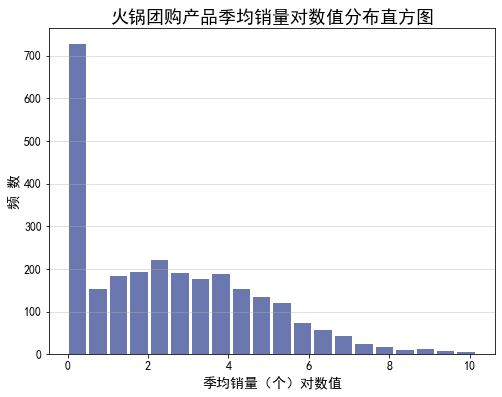

In [683]:
# 解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 画图
plt.figure(figsize=(8,6))
plt.hist(x=data_['log_quarterly.sales.volume'], bins=20, color='#2D3D8E', alpha=0.7, rwidth=0.85)
plt.xlabel('季均销量（个）对数值',fontsize=14)
plt.ylabel('频 数',fontsize=14)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.title('火锅团购产品季均销量对数值分布直方图',fontsize=18)
plt.grid(axis='y', alpha=0.5)
plt.show()

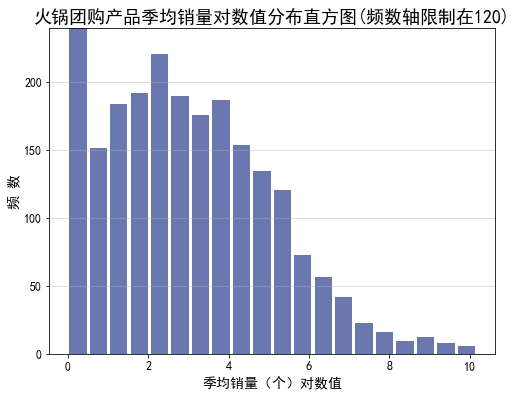

In [684]:
# 季均销售量几乎为0的太多；把坐标轴放缩到120重新画图
plt.figure(figsize=(8,6))
plt.hist(x=data_['log_quarterly.sales.volume'], bins=20, color='#2D3D8E', alpha=0.7, rwidth=0.85)
plt.xlabel('季均销量（个）对数值',fontsize=14)
plt.ylabel('频 数',fontsize=14)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.title('火锅团购产品季均销量对数值分布直方图(频数轴限制在120)',fontsize=18)
plt.grid(axis='y', alpha=0.5)
plt.ylim(0,240)
plt.show()

In [685]:
# 计算季均销售量几乎为0（<=1）的火锅团购产品占比
print('均销售量几乎为0（<=1）的火锅团购产品占比（%）：',
     round(sum(data_['log_quarterly.sales.volume'] == 0) / data_.shape[0]*100,2))

均销售量几乎为0（<=1）的火锅团购产品占比（%）： 21.28


**季均销售量几乎为0（<=1）的火锅团购产品占比为21.28%，当剔除这部分数据并取对数后，直方图的分布较接近于右偏的正态分布。**

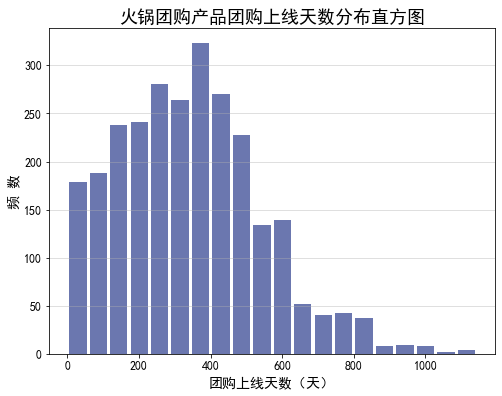

In [686]:
plt.figure(figsize=(8,6))
plt.hist(x=data_['online.intervel'], bins=20, color='#2D3D8E', alpha=0.7, rwidth=0.85)
plt.xlabel('团购上线天数（天）',fontsize=14)
plt.ylabel('频 数',fontsize=14)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.title('火锅团购产品团购上线天数分布直方图',fontsize=18)
plt.grid(axis='y', alpha=0.5)
plt.show()

**团购上线天数的直方图如上所示，大部分产品的团购上线天数在600以内。**

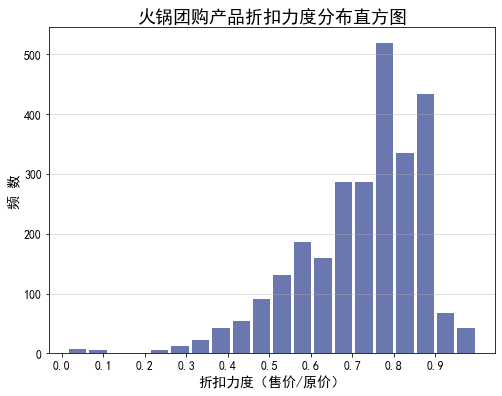

In [687]:
plt.figure(figsize=(8,6))
plt.hist(x=data_['discount'], bins=20, color='#2D3D8E', alpha=0.7, rwidth=0.85)
plt.xlabel('折扣力度（售价/原价）',fontsize=14)
plt.xticks(np.arange(0, 1, 0.1))
plt.ylabel('频 数',fontsize=14)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.title('火锅团购产品折扣力度分布直方图',fontsize=18)
plt.grid(axis='y', alpha=0.5)

plt.show()

**团购产品折扣力度直方图如上所示，可看到大多数折扣在7~9折左右。**

## >>> Q3：火锅团购商家店名高频词统计
* **将火锅团购商家店名高频词统计出来，并绘制出词云，简单陈述。**  
**提示：剔除无意义的词组，如“区”、“路”、“火锅”、“小区”、“分店”、“店”等；剔除非中文字符（数字和字母）。**

In [688]:
import pkuseg
 
# 以默认配置加载模型
seg = pkuseg.pkuseg() 

# 加载停用词表
stopwords = []
with open(r'.\stopwords.txt',encoding='utf-8') as f:
    stopwords = f.read()

# 手动添加无意义的高频词
for word in ['火锅','店','锅','城店','路店','村店']:
    stopwords += word+'\n'

# 进行分词，并去除停用词，且停用词中已包括符号和数字
data_['cut'] = data_['字段1'].apply(lambda x: [i for i in seg.cut(x) if i not in stopwords])

data_[['字段1','cut']].head(20)

,字段1,cut
0,巴蜀大魏道火锅(高新路店),"[巴蜀, 魏道, 高新路店]"
1,宽窄巷子火锅,"[宽窄, 巷子]"
2,重庆鼻祖老火锅,"[重庆, 鼻祖]"
3,六婆串串香火锅(凤城一路店),"[六婆, 串串, 香火锅, 凤城, 一路店]"
4,辣尚仙焖锅,"[辣尚, 仙焖]"
5,萤火虫新概念火锅,"[萤火虫, 概念]"
6,冯记猪肚鸡养生火锅,"[冯, 记猪, 肚, 鸡, 养生]"
7,张二毛火锅,[二毛]
8,康二姐串串香火锅(潘村店),"[康二姐, 串串, 香火锅, 潘村店]"
9,万家欢鱼火锅(曲江店),"[欢鱼, 曲江店]"


**词频统计：**

In [598]:
from nltk import FreqDist 

words = []
 
for content in data_['cut']:
    words.extend(content)


freq = FreqDist(words)  
print('店名高频词Top20：\n',freq.most_common(20))

店名高频词Top20：
 [('串串', 252), ('重庆', 222), ('私房', 129), ('自助', 122), ('鱼', 120), ('焖锅', 110), ('北京', 61), ('肥牛', 61), ('鸡公煲', 60), ('主题', 56), ('涮', 55), ('三汁', 55), ('凤城', 47), ('香火锅', 45), ('成都', 44), ('香火', 44), ('清真', 43), ('七婆', 41), ('涮锅', 40), ('串串香', 40)]


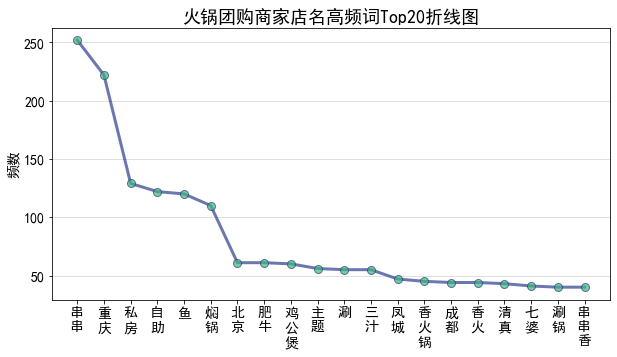

In [599]:
import matplotlib.pyplot as plt

x_ = [i[0] for i in freq.most_common(20)]
x = []
for word in x_: # 为了使词语纵向排列，从'串串' 变成'串\n串'
    tmp = ''
    for hanzi in word:
        tmp += hanzi+'\n'
    x.append(tmp[:-1]) # [:-1]是为了去掉末尾的换行符

y = [i[1] for i in freq.most_common(20)]

plt.figure(figsize=(10,5))
plt.plot(x,y,linewidth=3,color='#2D3D8E', alpha=0.7, marker='o', markerfacecolor='#3DBA78', markersize=8)
plt.ylabel('频数',fontsize=14)
plt.title('火锅团购商家店名高频词Top20折线图',fontsize=18)
plt.tick_params(labelsize=14)
plt.grid(axis='y', alpha=0.5)
plt.show()

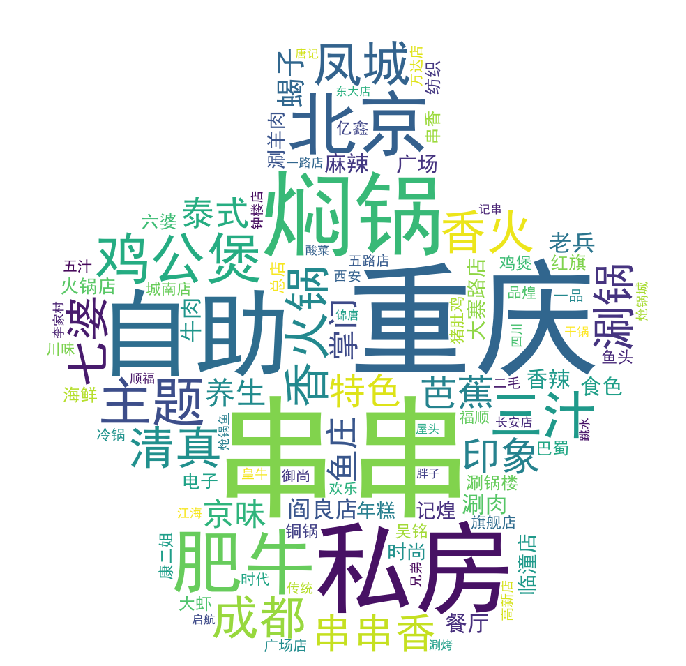

In [600]:
back_coloring_path = './hotpot.jpg'  # 火锅形状图
back_coloring = imread(back_coloring_path)  # 读取图片

text = ' '.join(words)

wordcloud = WordCloud(background_color='white',
                      margin=2,
                      max_words=100,  # 设置最多显示的词数
                      mask=back_coloring,  # 设置词云形状
                      font_path="simhei.ttf",  # 中文词图必须设置字体格式，否则会乱码，这里加载的是黑体
                      random_state=10, # 配色方案随机种子
                      collocations=False)  # collocations=False，词云图中才不会出现重复词
w = wordcloud.generate(text) 
plt.figure(figsize=(16,12))
plt.imshow(w)
plt.axis('off')  
plt.show()

**由词频统计与词云图可看出，火锅团购商家取店名的过程中:**
* **高频地名有“重庆”、“成都”、“北京”，其中“重庆”远多于其他地名；**
* **高频产品类型有“串串/串串香”、“焖锅”、“鸡公煲”，其中“串串/串串香”远多于其他产品；**
* **高频主打食材有“鱼”、“肥牛”等；**
* **此外，“自助”也是高频词，表明采取自助形式的火锅团购不少。**

## >>> Q4：销量与价格/节假日是否通用的关系探究
* **用箱线图表示销量与团购价的关系，及销量与节假日通用的关系；并解读**

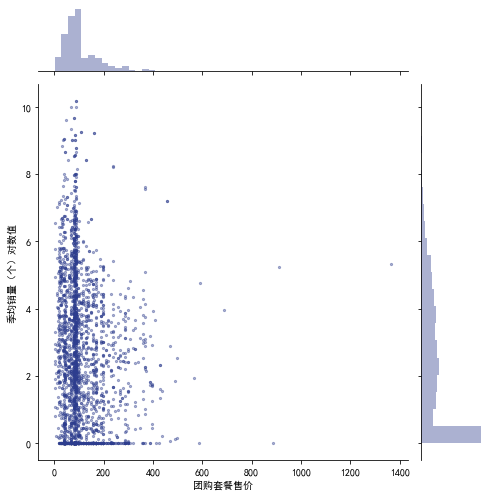

In [690]:
# 产品季均销量对数值与套餐价格散点图
tmp_df = data_[['log_quarterly.sales.volume', 'price']]
tmp_df = tmp_df.rename(columns={'log_quarterly.sales.volume':'季均销量（个）对数值', 'price':'团购套餐售价'})
sns.jointplot(x='团购套餐售价', y='季均销量（个）对数值',data=tmp_df, 
              height=7, color='#2D3D8E', alpha=0.4, s=5) # kind即控制蜂窝图
# plt.ylim(0)

**由产品季均销量对数值与套餐价格散点图可以看出，绝大多数套餐售价在400以内，销量高的套餐售价在100以下。**

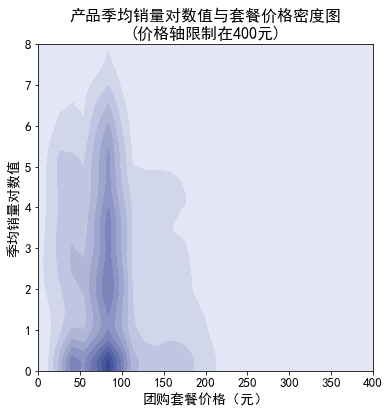

In [603]:
# 产品季均销量对数值与套餐价格密度图\n(价格轴限制在250以下
f, ax= plt.subplots(figsize = (6,6))
sns.kdeplot( data_[ 'price'],data_['log_quarterly.sales.volume'], shade=True, ax=ax, color='#2D3D8E')
ax.tick_params(labelsize=13)
plt.ylim(0,8)
plt.xlim(0,400)
plt.xlabel('团购套餐价格（元）',fontsize=14)
plt.ylabel('季均销量对数值',fontsize=14)
plt.title('产品季均销量对数值与套餐价格密度图\n(价格轴限制在400元)',fontsize=16)
plt.show()

**由套餐价格轴限制在400元的双变量密度图可以看出，销量高的套餐售价在50~100元之间。**

**用箱线图比较套餐售价高于100元与低于100元时，季均销量（对数值）的差异有多大。**

In [609]:
tmp_df = data_[['log_quarterly.sales.volume', 'price']]
tmp_df = tmp_df.sort_values(by='price') 
tmp_df.loc[tmp_df['price']<=100, 'price_level'] = '0~100'
tmp_df.loc[(tmp_df['price']>100) & (tmp_df['price']<=200), 'price_level'] = '100~200'
tmp_df.loc[(tmp_df['price']>200) & (tmp_df['price']<=400), 'price_level'] = '200~400'
tmp_df.loc[tmp_df['price']>400, 'price_level'] = '>400'
tmp_df.drop('price', axis = 1, inplace = True)
tmp_df = tmp_df.rename(columns={'log_quarterly.sales.volume':'季均销量对数值', 'price_level':'价格水平'})
tmp_df.head(5)

,季均销量对数值,价格水平
63,3.306236,0~100
1701,2.782158,0~100
184,1.078307,0~100
2173,4.932742,0~100
137,2.950190,0~100


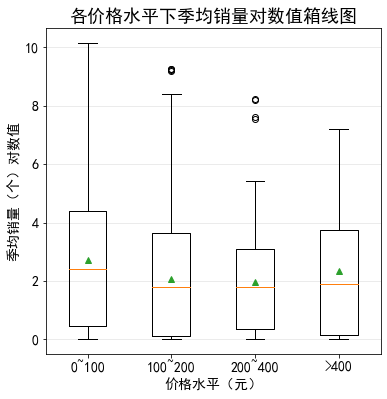

In [610]:
plt.figure(figsize=(6,6))
plt.title('各价格水平下季均销量对数值箱线图',fontsize=18)
labels = '0~100','100~200','200~400','>400'

plt.boxplot([tmp_df[tmp_df['价格水平'] == '0~100']['季均销量对数值'], 
             tmp_df[tmp_df['价格水平'] == '100~200']['季均销量对数值'],
             tmp_df[tmp_df['价格水平'] == '200~400']['季均销量对数值'], 
             tmp_df[tmp_df['价格水平'] == '>400']['季均销量对数值']], 
            labels = labels, showmeans = True)
plt.xlabel('价格水平（元）',fontsize=14)
plt.ylabel('季均销量（个）对数值',fontsize=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.grid(axis='y', alpha=0.3)

plt.show()

**由上图可见，在这 4 个价格水平中，价格在0~100之间的团购产品的销量平均数、中位数、上下四分位数均为最高，这与我们的认知相符。有意思的是，销量平均数和中位数次高的价格水平为最高的“大于400元”。通过结合价格与销量的散点图，我们可以发现在400元以上的团购产品非常少，但销量大多较可观；反观400元以下的团购产品，有非常多的产品季均销量不足一件，造成拖累。但若着眼于每个价格水平中最火热产品的销量，则是完全地随着价格升高而下降。**

In [611]:
tmp_df = data_[['log_quarterly.sales.volume', '非周末法定节假日通用']]
tmp_df = tmp_df.rename(columns={'log_quarterly.sales.volume':'季均销量对数值', '非周末法定节假日通用':'非节假日通用'})
tmp_df.head(5)

,季均销量对数值,非节假日通用
0,1.689481,0
1,7.535936,0
2,6.145812,1
3,0.807365,0
4,1.863059,1


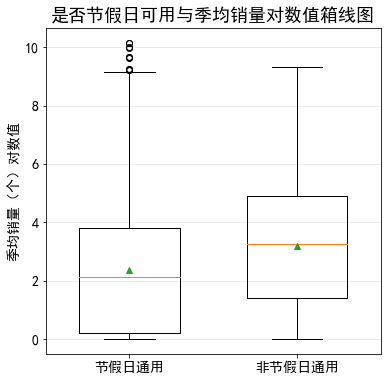

In [612]:
plt.figure(figsize=(6,6))
plt.title('是否节假日可用与季均销量对数值箱线图',fontsize=18)
labels = '节假日通用','非节假日通用'

plt.boxplot([tmp_df[tmp_df['非节假日通用'] == 0]['季均销量对数值'], 
             tmp_df[tmp_df['非节假日通用'] == 1]['季均销量对数值']],
            labels = labels, showmeans = True, widths = 0.6)
plt.ylabel('季均销量（个）对数值',fontsize=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.grid(axis='y', alpha=0.3)

plt.show()

In [627]:
print('非节假日通用的产品占比为',round(sum(tmp_df['非节假日通用'] == 0) / tmp_df.shape[0],3)*100,'%')

非节假日通用的产品占比为 85.0 %


**绝大多数的产品均为“非节假日通用”，占比达到85%。由上图可见，“非节假日通用”的产品销量整体明显高于“节假日通用”的产品，但“节假日通用”的最火热产品销量超过“非节假日通用”。**

## >>> Q5：销量与店名中包含的各类词汇的关系探究
* **用箱线图表示店名中包含的各类词汇与团购销量的关系，并解读**

In [630]:
# 准备数据

# rv_list = ['店名含地名', '店名含食材', '店名含口味', '店名含烹饪方式', '店名含人物']
rv_list = ['place', 'food', 'taste', 'cook', 'people', 'style', 'HighFreq']
data = pd.read_csv(r'.\HotPot.csv')
tmp_df = data[rv_list]
tmp_df = pd.concat([tmp_df,data_['log_quarterly.sales.volume']],axis=1)
# tmp_df = tmp_df.rename(columns={'log_quarterly.sales.volume':'季均销量对数值'})
tmp_df.head()

,place,food,taste,cook,people,style,HighFreq,log_quarterly.sales.volume
0,是,否,否,否,否,川系,2,1.689481
1,否,否,否,否,否,川系,1,7.535936
2,是,否,否,否,否,川系,3,6.145812
3,否,否,是,否,是,川系,4,0.807365
4,否,否,是,是,否,川系,4,1.863059


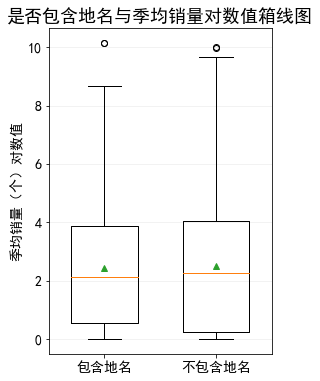

In [631]:
plt.figure(figsize=(4,6))
plt.title('是否包含地名与季均销量对数值箱线图',fontsize=18)
labels = '包含地名','不包含地名'

plt.boxplot([tmp_df[tmp_df['place'] == '是']['log_quarterly.sales.volume'], 
             tmp_df[tmp_df['place'] == '否']['log_quarterly.sales.volume']],
            labels = labels, showmeans = True, widths = 0.6)
plt.ylabel('季均销量（个）对数值',fontsize=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.grid(axis='y', alpha=0.2)

plt.show()

**由上可见，店名中是否包含地名对于产品销量的影响并不明显。**

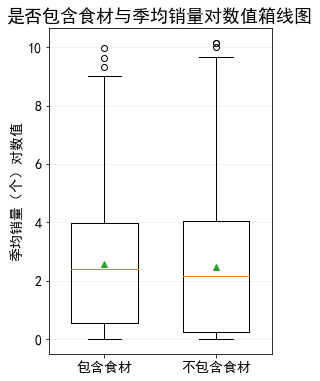

In [632]:
plt.figure(figsize=(4,6))
plt.title('是否包含食材与季均销量对数值箱线图',fontsize=18)
labels = '包含食材','不包含食材'

plt.boxplot([tmp_df[tmp_df['food'] == '是']['log_quarterly.sales.volume'], 
             tmp_df[tmp_df['food'] == '否']['log_quarterly.sales.volume']],
            labels = labels, showmeans = True, widths = 0.6)
plt.ylabel('季均销量（个）对数值',fontsize=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.grid(axis='y', alpha=0.2)

plt.show()

**由上可见，店名包含食材的产品销量中位数、平均数、下四分位数均高于店名不包含食材的情况，即店名中包含食材对于产品销量有一定正面影响。猜测其原因，也许是因为包含食材的店名更清晰直观、容易使消费者明确火锅店的主打食材、或更容易激起消费者食欲。**

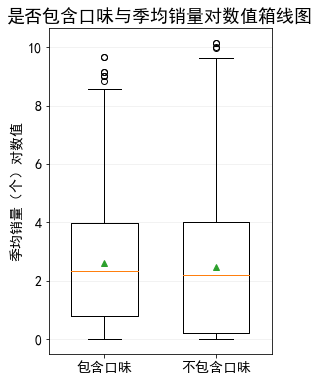

In [636]:
plt.figure(figsize=(4,6))
plt.title('是否包含口味与季均销量对数值箱线图',fontsize=18)
labels = '包含口味','不包含口味'

plt.boxplot([tmp_df[tmp_df['taste'] == '是']['log_quarterly.sales.volume'], 
             tmp_df[tmp_df['taste'] == '否']['log_quarterly.sales.volume']],
            labels = labels, showmeans = True, widths = 0.6)
plt.ylabel('季均销量（个）对数值',fontsize=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.grid(axis='y', alpha=0.2)

plt.show()

**由上可见，店名包含口味的产品销量中位数、平均数、下四分位数均高于店名不包含食材的情况，即店名中包含口味对于产品销量有一定正面影响，但不包含口味的店名的产品销量上限高于店名包含口味的情况。猜测其原因，也许是因为包含口味的店名更清晰直观、容易使消费者明确、或更容易激起消费者食欲。**

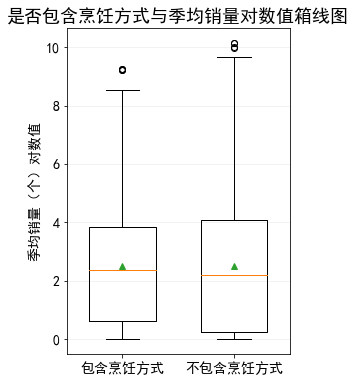

In [637]:
plt.figure(figsize=(4,6))
plt.title('是否包含烹饪方式与季均销量对数值箱线图',fontsize=18)
labels = '包含烹饪方式', '不包含烹饪方式'

plt.boxplot([tmp_df[tmp_df['cook'] == '是']['log_quarterly.sales.volume'], 
             tmp_df[tmp_df['cook'] == '否']['log_quarterly.sales.volume']],
            labels = labels, showmeans = True, widths = 0.6)
plt.ylabel('季均销量（个）对数值',fontsize=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.grid(axis='y', alpha=0.2)

plt.show()

**由上可见，店名中是否包含烹饪方式对于产品销量的影响并不明显。**

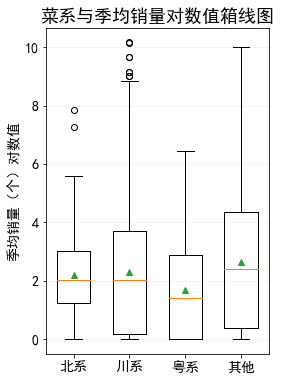

In [641]:
plt.figure(figsize=(4,6))
plt.title('菜系与季均销量对数值箱线图',fontsize=18)
labels = '北系', '川系', '粤系', '其他'

plt.boxplot([tmp_df[tmp_df['style'] == '北系']['log_quarterly.sales.volume'], 
             tmp_df[tmp_df['style'] == '川系']['log_quarterly.sales.volume'],
             tmp_df[tmp_df['style'] == '粤系']['log_quarterly.sales.volume'],
             tmp_df[tmp_df['style'] == '其他']['log_quarterly.sales.volume']],
            labels = labels, showmeans = True, widths = 0.6)
plt.ylabel('季均销量（个）对数值',fontsize=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.grid(axis='y', alpha=0.2)

plt.show()

**由上可见，在北、川、粤三系的火锅中，粤系最不受欢迎，川系人气最高。**

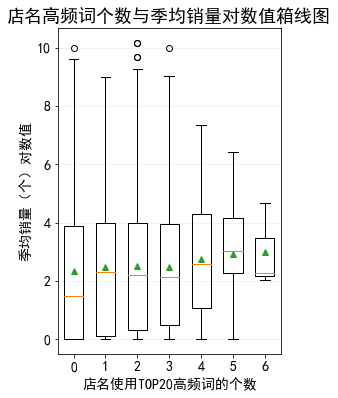

In [644]:
plt.figure(figsize=(4,6))
plt.title('店名高频词个数与季均销量对数值箱线图',fontsize=18)
labels = 0, 1, 2, 3, 4, 5, 6

plt.boxplot([tmp_df[tmp_df['HighFreq'] == 0]['log_quarterly.sales.volume'],
             tmp_df[tmp_df['HighFreq'] == 1]['log_quarterly.sales.volume'], 
             tmp_df[tmp_df['HighFreq'] == 2]['log_quarterly.sales.volume'],
             tmp_df[tmp_df['HighFreq'] == 3]['log_quarterly.sales.volume'],
             tmp_df[tmp_df['HighFreq'] == 4]['log_quarterly.sales.volume'],
             tmp_df[tmp_df['HighFreq'] == 5]['log_quarterly.sales.volume'],
             tmp_df[tmp_df['HighFreq'] == 6]['log_quarterly.sales.volume']],
            labels = labels, showmeans = True, widths = 0.6)
plt.ylabel('季均销量（个）对数值',fontsize=14)
plt.xlabel('店名使用TOP20高频词的个数',fontsize=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.grid(axis='y', alpha=0.2)

plt.show()

**由上可见，店名中包含高频词的数量越多，销量整体会有所提升。但人气最高的产品并不是诞生于高频词堆叠太多的产品中。**

## >>> Q6：建立线性回归模型，探究影响团购销量的主要因素

In [691]:
# 对连续型变量做数据标准化
from sklearn import preprocessing
for rv in ['discount', 'price', 'time.duration', '评分', '评论数', 'online.intervel','price_per_person']:
    data_[rv] = preprocessing.scale([i for i in data_[rv]])

#### 将数据集分为测试集和训练集。

In [695]:
rv_list = [x for x in data_.columns if x not in ['ID', '字段1', '字段2', 'cut', 'quarterly.sales.volume']]
reg_data = data_[rv_list]
print('Shape of total data:', reg_data.shape)
train_data = reg_data.sample(frac = 0.7, random_state = 0, axis = 0, replace = False)
print('Shape of training data:', train_data.shape)
test_data = reg_data[~reg_data.index.isin(train_data.index)]
print('Shape of testing data:', test_data.shape)

rv_list.remove('log_quarterly.sales.volume') # 自变量列表

Shape of total data: (2688, 41)
Shape of training data: (1882, 41)
Shape of testing data: (806, 41)


In [696]:
# RMSE 与 r2 计算
from sklearn.metrics import mean_squared_error, r2_score

def cal_metrics(model, data_df):
    y_ = data_df['log_quarterly.sales.volume']
    y_pred = model.predict(sm.add_constant(data_df[rv_list]))
    return r2_score(y_, y_pred), mean_squared_error(y_, y_pred)**0.5

In [697]:
model_full = OLS(train_data['log_quarterly.sales.volume'], sm.add_constant(train_data[rv_list])).fit()
# y_test_pred = model_full.predict(sm.add_constant(test_data[rv_list]))
r2_train, rmse_train = cal_metrics(model_full, train_data)
r2_test, rmse_test = cal_metrics(model_full, test_data)

print('R2 on training set:', round(r2_train,4))
print('RMSE on training set:', round(rmse_train,4))
print('R2 on testing set:', round(r2_test,4))
print('RMSE on testing set:', round(rmse_test,4))

R2 on training set: 0.5078
RMSE on training set: 1.5357
R2 on testing set: 0.5071
RMSE on testing set: 1.5362


In [653]:
# 计算 VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['feature'] = train_data[rv_list].columns
vif['VIF'] = [variance_inflation_factor(train_data[rv_list].values, i) for i in range(train_data[rv_list].shape[1])]
vif.round(1)

,feature,VIF
0,discount,1.3
1,price,8.6
2,time.duration,1.1
3,评分,1.2
4,评论数,1.1
5,online.intervel,1.3
6,HighFreq,1.5
7,num_people,77.0
8,price_per_person,8.4
9,钱包新客最高再减20元,1.1


**去掉 VIF 值为 77 的num_people，重新回归。**

In [654]:
rv_list.remove('num_people')
model_full = OLS(train_data['log_quarterly.sales.volume'], sm.add_constant(train_data[rv_list])).fit()
# y_test_pred = model_full.predict(sm.add_constant(test_data[rv_list]))
r2_train, rmse_train = cal_metrics(model_full, train_data)
r2_test, rmse_test = cal_metrics(model_full, test_data)

print('R2 on training set:', round(r2_train,4))
print('RMSE on training set:', round(rmse_train,4))
print('R2 on testing set:', round(r2_test,4))
print('RMSE on testing set:', round(rmse_test,4))

R2 on training set: 0.5078
RMSE on training set: 2.3585
R2 on testing set: 0.5071
RMSE on testing set: 2.36


In [655]:
# 再次计算 VIF
vif = pd.DataFrame()
vif['feature'] = train_data[rv_list].columns
vif['VIF'] = [variance_inflation_factor(train_data[rv_list].values, i) for i in range(train_data[rv_list].shape[1])]
vif.round(1)

,feature,VIF
0,discount,1.3
1,price,8.5
2,time.duration,1.1
3,评分,1.2
4,评论数,1.1
5,online.intervel,1.3
6,HighFreq,5.9
7,price_per_person,8.3
8,钱包新客最高再减20元,18.8
9,有立减优惠,1.1


**去掉 VIF 为 18.8 的“钱包新客最高再减20元”，重新回归。此时VIF均处于10以下。**

In [656]:
rv_list.remove('钱包新客最高再减20元')
model_full = OLS(train_data['log_quarterly.sales.volume'], sm.add_constant(train_data[rv_list])).fit()
# y_test_pred = model_full.predict(sm.add_constant(test_data[rv_list]))
r2_train, rmse_train = cal_metrics(model_full, train_data)
r2_test, rmse_test = cal_metrics(model_full, test_data)

print('R2 on training set:', round(r2_train,4))
print('RMSE on training set:', round(rmse_train,4))
print('R2 on testing set:', round(r2_test,4))
print('RMSE on testing set:', round(rmse_test,4))

vif = pd.DataFrame()
vif['feature'] = train_data[rv_list].columns
vif['VIF'] = [variance_inflation_factor(train_data[rv_list].values, i) for i in range(train_data[rv_list].shape[1])]
vif.round(1)

R2 on training set: 0.5034
RMSE on training set: 2.38
R2 on testing set: 0.4984
RMSE on testing set: 2.4015


,feature,VIF
0,discount,1.3
1,price,8.4
2,time.duration,1.0
3,评分,1.2
4,评论数,1.1
5,online.intervel,1.3
6,HighFreq,5.8
7,price_per_person,8.2
8,有立减优惠,1.1
9,新城区,1.5


In [657]:
print(model_full.summary())

                                OLS Regression Results                                
Dep. Variable:     log_quarterly.sales.volume   R-squared:                       0.503
Model:                                    OLS   Adj. R-squared:                  0.493
Method:                         Least Squares   F-statistic:                     49.16
Date:                        Mon, 13 Apr 2020   Prob (F-statistic):          1.49e-248
Time:                                18:03:24   Log-Likelihood:                -3486.4
No. Observations:                        1882   AIC:                             7051.
Df Residuals:                            1843   BIC:                             7267.
Df Model:                                  38                                         
Covariance Type:                    nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

**参数分析：**
* **在0.05的置信水平下，连续型变量中，评分、评论数对团购产品销量有显著正相关关系，表明评分高的产品更受欢迎，而评论数天然就是销量的另一个表现；而在线天数、人均价格对团购产品销量有显著负面关系，人均价格越高、能承受的消费者便越少，而店家在线天数对季均销量的负面影响主要体现于季均销量的计算方式为“累计销量/团购在线天数×90”，天然具有负向关系。**
* **在0.05的置信水平下，以下类别变量的不同取值会对销量造成显著影响：**
    * **店面的地理位置：在各个行政区中，阎良区的店销量最高，碑林区次之，临潼区的店销量最低。**
    * **非周末法定节假日通用的产品销量显著高于周末法定节假日通用的产品。**
    * **描述中未提及wifi会使销量显著下降。** 
    * **仅限1人使用的产品销量显著高于其他人数，限5-12人使用的产品销量最低，体现了“一人食”的火锅的增长潜力。**
    * **店名包含食材和口味都显著增加了销量，或许是这样的店名能更直观清晰地表达产品定位、吸引消费者眼球、或是更能激起消费者食欲。**
    * **不同的菜系产品销量显著不同，销量最高的种类为不属于北、川、粤三系的其他综合性类别，北、川、粤三系中粤系销量最低，川系销量最高。**

**正则化采用elastic_net，具体形式为最小化以下损失函数：**  

**$LOSS = 0.5 * R S S / n+$ alpha $*\left(\left(1-L 1_{-} w t\right) * | \text { params }\left.\right|_{2} ^{2} / 2+L 1_{-} w t * | \text { params }\left.\right|_{1}\right)$**

In [658]:
model_L1 = OLS(train_data['log_quarterly.sales.volume'], sm.add_constant(train_data[rv_list])).fit_regularized(alpha=0.01)
# y_test_pred = model_L1.predict(sm.add_constant(test_data[rv_list]))
r2_train, rmse_train = cal_metrics(model_L1, train_data)
r2_test, rmse_test = cal_metrics(model_L1, test_data)

print('R2 on training set:', round(r2_train,4))
print('RMSE on training set:', round(rmse_train,4))
print('R2 on testing set:', round(r2_test,4))
print('RMSE on testing set:', round(rmse_test,4))

R2 on training set: 0.4919
RMSE on training set: 2.4349
R2 on testing set: 0.4942
RMSE on testing set: 2.4216


**在未正则化之前，可以看到训练集与测试集的结果相近，即不存在过拟合。当加入正则化力度后，模型拟合能力下降，也再次证实了无须正则化。**